<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 3

</h4>

# Personal Data

In [36]:
# Set your student number
student_number = 400101861
Name = 'ahmadreza'
Last_Name = 'majlesara'

# Autoencoders (25 Points)

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

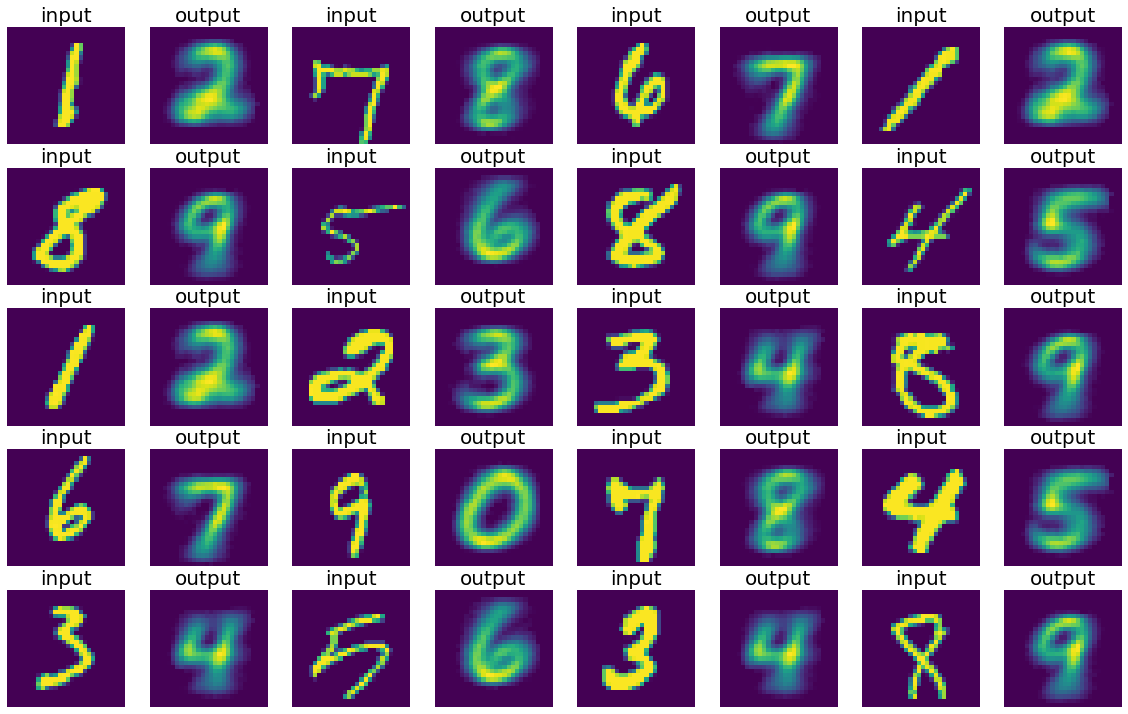

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [37]:
from ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)


c:\Users\Digi Max\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [38]:
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("Y_train shape: ", Y_train.shape)
print("Y_val shape: ", Y_val.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (50400, 28, 28)
X_val shape:  (5600, 28, 28)
X_test shape:  (14000, 28, 28)
Y_train shape:  (50400, 28, 28)
Y_val shape:  (5600, 28, 28)
Y_test shape:  (14000, 28, 28)


## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [39]:
import torch
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [40]:
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X).float().unsqueeze(1)  
        self.Y = torch.tensor(Y).float().unsqueeze(1)
        self.y = torch.tensor(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [41]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_autoencoder(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader) -> (float, float):
    model.to(device)
    model.train()
    losses = []
    maes = []

    for X_batch, Y_batch, _ in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        optimizer.zero_grad()

        predictions = model(X_batch)
        loss = nn.MSELoss()(predictions, Y_batch)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        mae = nn.L1Loss()(predictions, Y_batch).item()
        maes.append(mae)

    Outloss = sum(losses) / len(losses)  
    accuracy = 1 - sum(maes) / len(maes)
    return Outloss, accuracy

def eval_autoencoder(model: nn.Module, dataloader: DataLoader) -> (float, float):
    model.to(device)
    model.eval()
    losses = []
    maes = []

    with torch.no_grad():
        for X_batch, Y_batch, _ in dataloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            
            reconstructed = model(X_batch)
            loss = nn.MSELoss()(reconstructed, Y_batch)
            losses.append(loss.item())
            
            mae = nn.L1Loss()(reconstructed, Y_batch).item()
            maes.append(mae)
    
    average_loss = sum(losses) / len(losses)
    accuracy = 1 - sum(maes) / len(maes)
    return average_loss, accuracy

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [43]:
import torch.optim as optim 
ae = AutoEncoder().to(device=device)
optimizer = optim.Adam(ae.parameters(), lr=0.001)


## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [52]:
def train_and_validate(model, train_dataloader, val_dataloader, optimizer, num_epochs):
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(1, num_epochs + 1):
        train_loss , train_acc = train_autoencoder(model, optimizer, train_dataloader)
        val_loss  , val_acc = eval_autoencoder(model, val_dataloader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, train accuracy: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}")

    print(f"Best validation loss: {best_val_loss:.4f}")
    return best_model_state

best_model_state = train_and_validate(ae, train_dataloader, val_dataloader, optimizer, num_epochs=30)

Epoch 1/30, Train Loss: 0.0552, train accuracy: 0.8728, Val Loss: 0.0560, Val accuracy: 0.8711
Epoch 2/30, Train Loss: 0.0551, train accuracy: 0.8730, Val Loss: 0.0559, Val accuracy: 0.8721
Epoch 3/30, Train Loss: 0.0550, train accuracy: 0.8732, Val Loss: 0.0561, Val accuracy: 0.8727
Epoch 4/30, Train Loss: 0.0550, train accuracy: 0.8733, Val Loss: 0.0560, Val accuracy: 0.8705
Epoch 5/30, Train Loss: 0.0550, train accuracy: 0.8733, Val Loss: 0.0559, Val accuracy: 0.8719
Epoch 6/30, Train Loss: 0.0548, train accuracy: 0.8736, Val Loss: 0.0559, Val accuracy: 0.8720
Epoch 7/30, Train Loss: 0.0548, train accuracy: 0.8736, Val Loss: 0.0559, Val accuracy: 0.8721
Epoch 8/30, Train Loss: 0.0548, train accuracy: 0.8738, Val Loss: 0.0559, Val accuracy: 0.8715
Epoch 9/30, Train Loss: 0.0547, train accuracy: 0.8738, Val Loss: 0.0560, Val accuracy: 0.8715
Epoch 10/30, Train Loss: 0.0547, train accuracy: 0.8740, Val Loss: 0.0561, Val accuracy: 0.8726
Epoch 11/30, Train Loss: 0.0546, train accuracy: 

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [53]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
ae.load_state_dict(best_model_state)

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

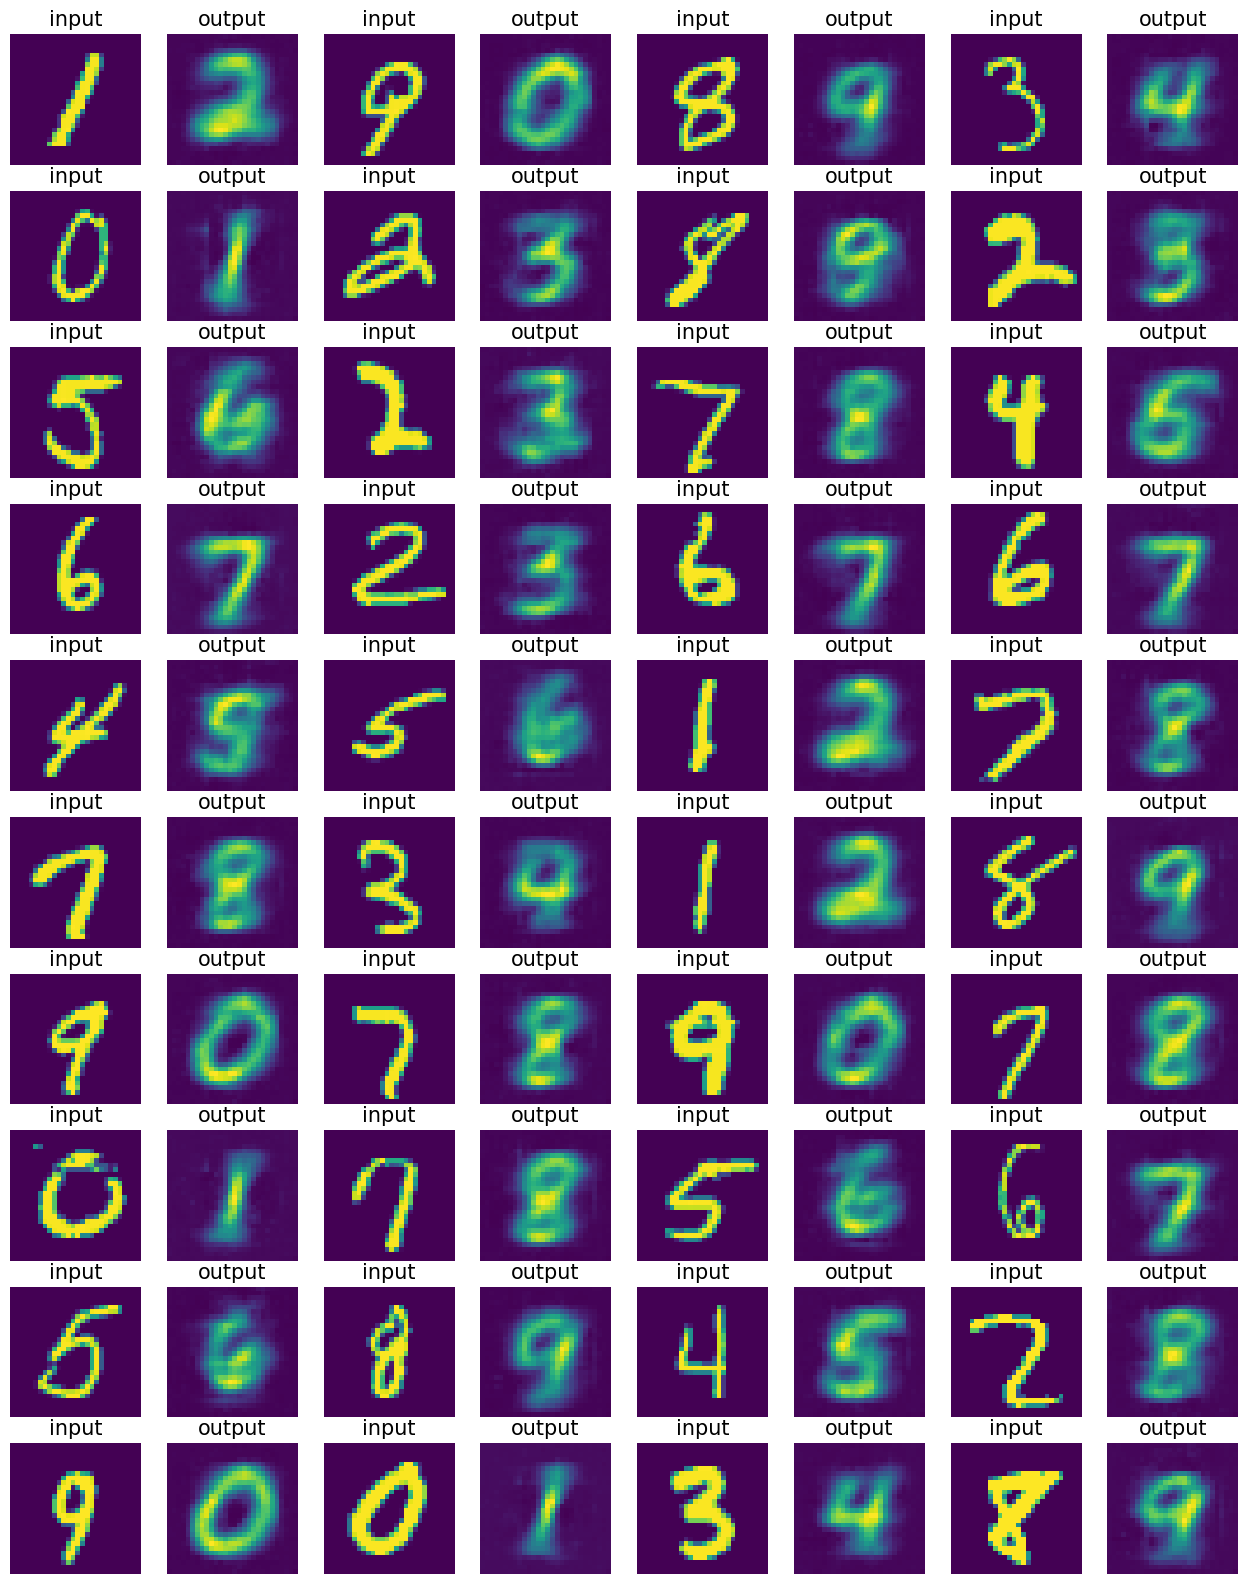

In [68]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader


test_dataloader = DataLoader(
    MnistNextDigitDataset(X_test, Y_test, y_test),
    batch_size=1024,
    shuffle=False
)
ae.eval()

num_examples = 40
test_iterator = iter(test_dataloader)
images, _, _ = next(test_iterator)
images = images[:num_examples]

with torch.no_grad():
    images = images.to(device)
    reconstructed_images = ae(images).cpu()
    reconstructed_images = (reconstructed_images - reconstructed_images.min())
    reconstructed_images[torch.isnan(reconstructed_images)] = 0

fig, axs = plt.subplots(10, 8, figsize=(16, 20))
for i in range(num_examples):
    axs[i//4, 2*i%8].imshow(images[i].squeeze().cpu(), cmap='viridis')
    axs[i//4, 2*i%8].set_title('input', fontsize=15)
    axs[i//4, 2*i%8].axis('off')

    # Plot reconstructed images
    axs[i//4, 2*i%8+1].imshow(reconstructed_images[i].squeeze(), cmap='viridis')
    axs[i//4, 2*i%8+1].set_title('output', fontsize=15)
    axs[i//4, 2*i%8+1].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()
